In [153]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

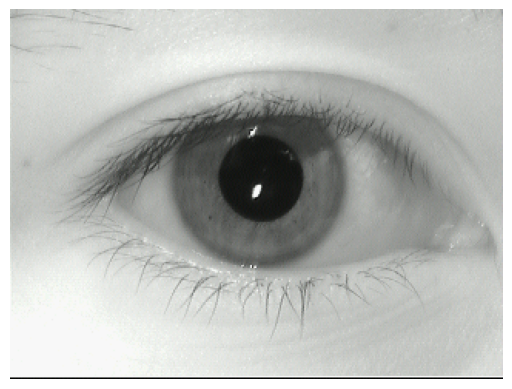

In [154]:
path = 'img/zulaikahr2.bmp'
# # path = 'IMG_026_L_4.jpg'
# path='img/chuj.png'
# path='img/menel.jpg'

# path = 'zulaikahr2.bmp'
img = cv2.imread(path)
img_original= img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

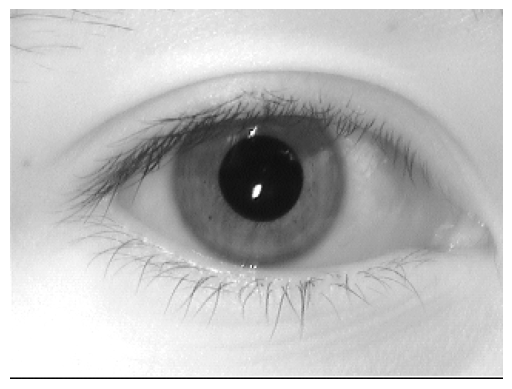

In [155]:
# Covert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
plt.axis('off')
plt.show()

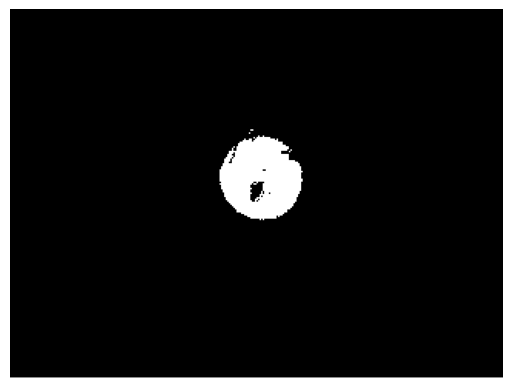

In [156]:
# Binarize to find the pupil
_, binary = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

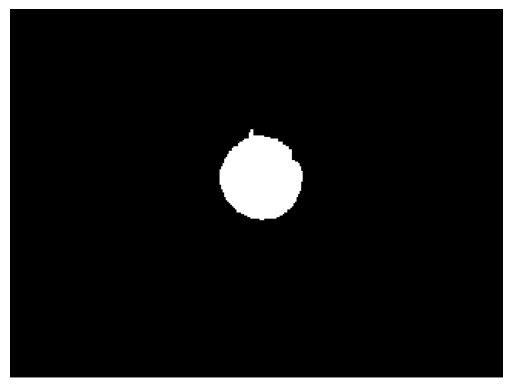

In [157]:
#Closing
kernel = np.ones((5,5), np.uint8)
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
binary=closing
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

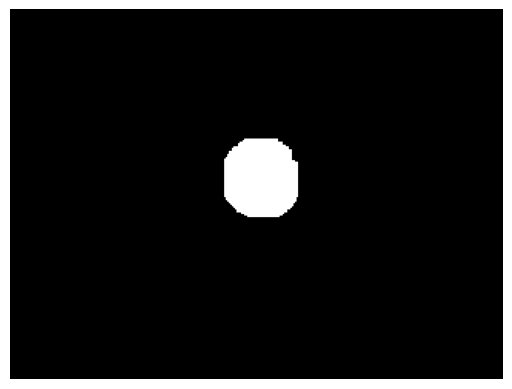

In [158]:
# Morphological operations to clean up the image - remove noise
kernel = np.ones((3,3), np.uint8)
binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=10)
plt.imshow(binary, cmap='gray')
plt.axis('off')
plt.show()

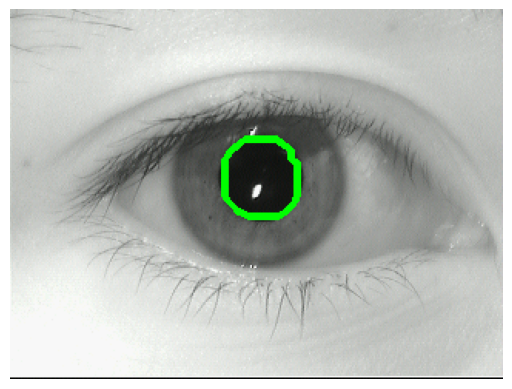

In [159]:
# Plot the binary mask on the original image
# Find contours
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Find the largest contour
largest_contour = max(contours, key=cv2.contourArea)
# Draw the largest contour
img_copy = img.copy()
cv2.drawContours(img_copy, [largest_contour], -1, (0, 255, 0), 3)
plt.imshow(img_copy)
plt.axis('off')
plt.show()

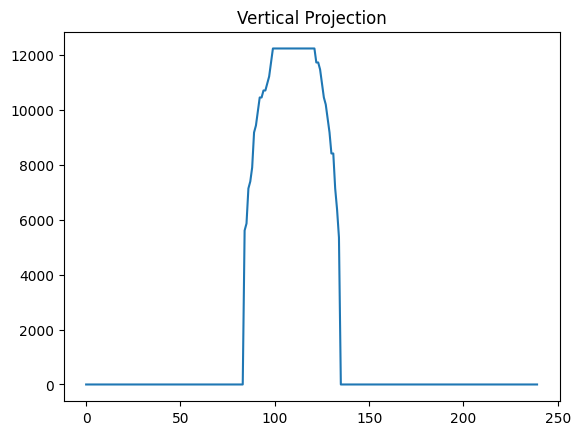

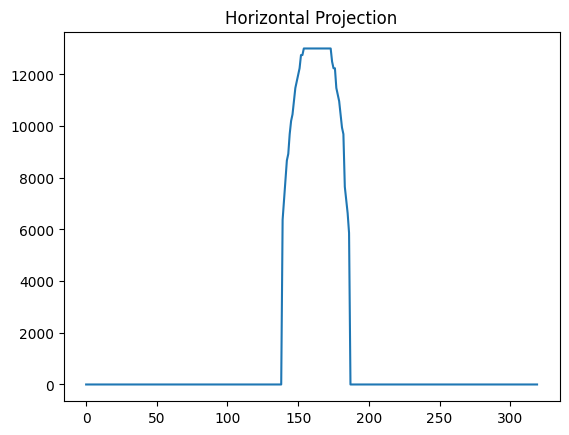

Pupil center: (154, 99)


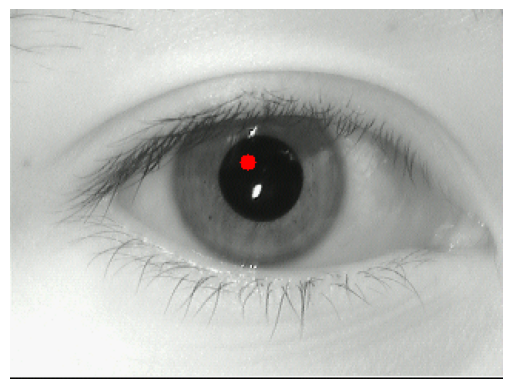

New radius: 25
New center: (162, 109)
Pupil radius: 25


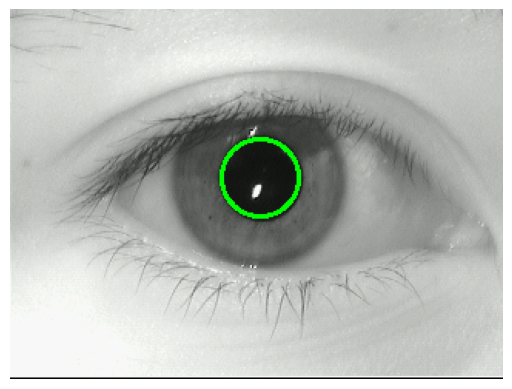

In [160]:
# Projections to find the center of the pupil
h, w = binary.shape
vertical_projection = np.sum(binary, axis=1)
horizontal_projection = np.sum(binary, axis=0)
plt.plot(vertical_projection)
plt.title('Vertical Projection')
plt.show()
plt.plot(horizontal_projection)
plt.title('Horizontal Projection')
plt.show()

# Find the center of the pupil
vertical_center = np.argmax(vertical_projection)
horizontal_center = np.argmax(horizontal_projection)
print(f'Pupil center: ({horizontal_center}, {vertical_center})')

# Draw the center on the original image
img_with_center = img.copy()
cv2.circle(img_with_center, (horizontal_center, vertical_center), 5, (255, 0, 0), -1)
plt.imshow(img_with_center)
plt.axis('off')
plt.show()

# Find the diameter of the pupil by looking in both vertical and horizontal directions
vertical_diameter = 0
for i in range(vertical_center, h):
    if binary[i, horizontal_center] == 0:
        vertical_diameter = i - vertical_center
        v_max = i
        break
for i in range(vertical_center, -1, -1):
    if binary[i, horizontal_center] == 0:
        vertical_diameter += vertical_center - i
        v_min = i
        break

horizontal_diameter = 0
for j in range(horizontal_center, w):
    if binary[vertical_center, j] == 0:
        horizontal_diameter = j - horizontal_center
        h_max = j
        break
for j in range(horizontal_center, -1, -1):
    if binary[vertical_center, j] == 0:
        horizontal_diameter += horizontal_center - j
        h_min = j
        break

# Another way to calculate radius - find v_max, v_min, h_max, h_min of the distribution
vertical_max_freq = vertical_projection[vertical_center]
horizonal_max_freq = horizontal_projection[horizontal_center]
for j in range(vertical_center, h):
    if vertical_projection[j] < vertical_max_freq * 0.2: # 0.2 - to be tuned
        v_max = j
        break
for j in range(vertical_center, -1, -1):
    if vertical_projection[j] < vertical_max_freq * 0.2: # 0.2 - to be tuned
        v_min = j
        break
for j in range(horizontal_center, w):
    if horizontal_projection[j] < horizonal_max_freq * 0.2: # 0.2 - to be tuned
        h_max = j
        break
for j in range(horizontal_center, -1, -1):
    if horizontal_projection[j] < horizonal_max_freq * 0.2: # 0.2 - to be tuned
        h_min = j
        break

new_radius = (v_max - v_min + h_max - h_min) // 4
print(f'New radius: {new_radius}')
new_center = (h_max + h_min) // 2, (v_max + v_min) // 2
print(f'New center: {new_center}')

# Take the average of vertical and horizontal diameters and divide by 2 to get the radius
radius = (vertical_diameter + horizontal_diameter) // 4
print(f'Pupil radius: {radius}')


# Draw the pupil on the original image
img_with_pupil = img.copy()
# cv2.circle(img_with_pupil, (horizontal_center, vertical_center), radius, (0, 255, 0), 2)
cv2.circle(img_with_pupil, new_center, new_radius, (0, 255, 0), 2)

plt.imshow(img_with_pupil)
plt.axis('off')
plt.show()

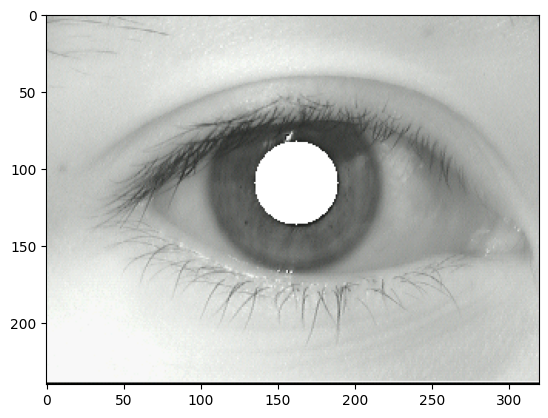

In [161]:
#change evrything inside the cicrcle to white
mask = np.zeros_like(img)
mask = cv2.circle(mask, new_center, new_radius+2, (255, 255, 255), -1)
# Keep the original image where mask is 0 (outside circle)
img_with_pupil = img.copy()
# Set pixels to white where mask is non-zero (inside circle)
img_with_pupil[mask > 0] = 255
plt.imshow(img_with_pupil)


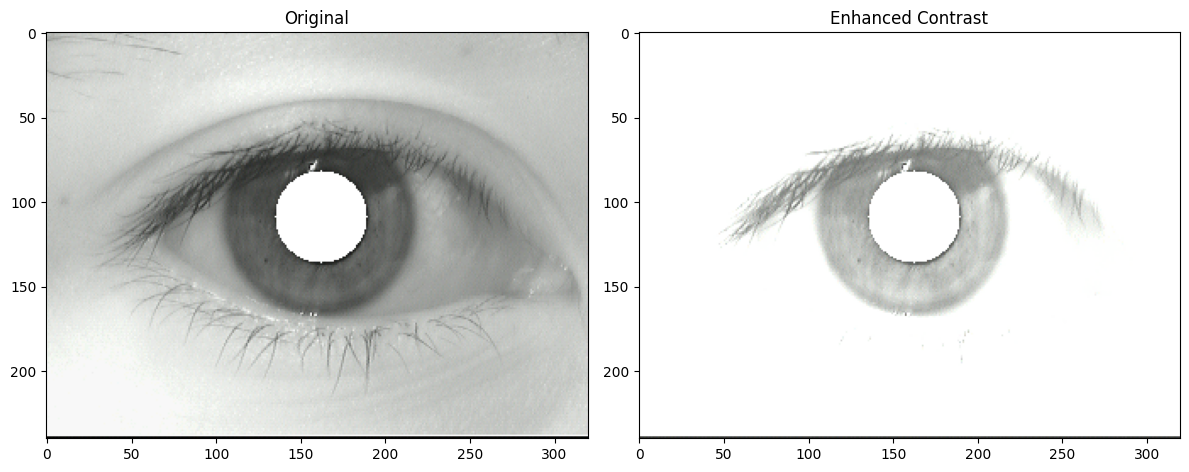

In [162]:
# Make dark pixels darker and light pixels lighter in img_with_pupil
# Method 1: Using cv2.convertScaleAbs() for contrast enhancement
alpha = 1.5  # Contrast control (1.0-3.0)
beta = 50     # Brightness control (0-100)
enhanced_img = cv2.convertScaleAbs(img_with_pupil, alpha=alpha, beta=beta)

# Alternative Method 2: Using histogram equalization for better contrast
# enhanced_img = cv2.equalizeHist(img_with_pupil)
# Note: equalizeHist works only on grayscale images

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img_with_pupil, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Enhanced Contrast")
plt.imshow(enhanced_img, cmap='gray')
plt.tight_layout()
plt.show()

In [163]:
# enhanced_img[int(vertical_center), int(horizontal_center - 1.1 * radius):int(horizontal_center + 1.1 * radius)]=255

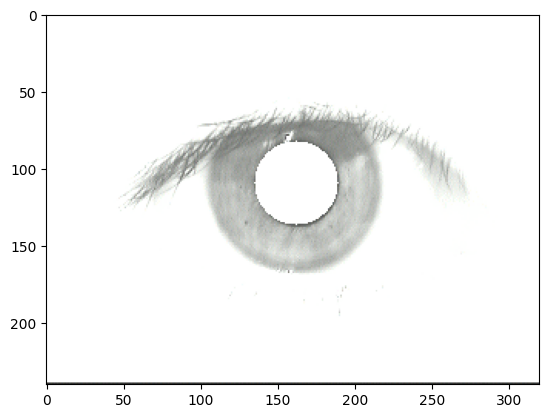

In [164]:
plt.imshow(enhanced_img, cmap='gray')

In [165]:
import numpy as np

# Assuming `enhanced_img` is a 2D numpy array representing the image
# cx, cy: coordinates of the center
# r: radius of the inner circle

def calculate_mean_on_horizontal_line(enhanced_img, cx, cy, r):
    outer_radius = int(1.2 * (r + 2))  # Adjusted outer radius
    inner_radius = r+2

    # Define the horizontal line range
    x_min = max(0, cx - outer_radius)
    x_max = min(enhanced_img.shape[1], cx + outer_radius)

    # Collect pixel values excluding the inner circle
    pixel_values = []
    for x in range(x_min, x_max):
        distance = abs(x - cx)  # Horizontal distance from the center
        if inner_radius < distance <= outer_radius:
            pixel_values.append(enhanced_img[cy, x])

    # Calculate the mean value
    if pixel_values:
        mean_value = np.mean(pixel_values)
    else:
        mean_value = 0  # Default if no pixels are valid

    return mean_value

# Example usage
cx, cy, r = 162, 109, 25  # Example center and radius
mean_value = calculate_mean_on_horizontal_line(enhanced_img, cx, cy, r)
print("Mean value:", mean_value)

Mean value: 165.55555555555554


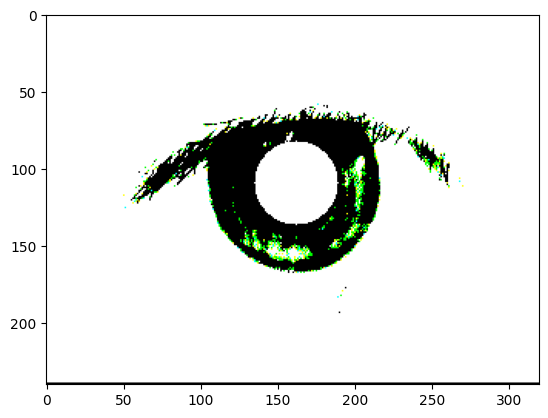

In [166]:


# Binarize the image using the mean pixel value as threshold
# if < than threshold -> 0
_, binary = cv2.threshold(enhanced_img, min(1.25*mean_value,220), 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap='gray')

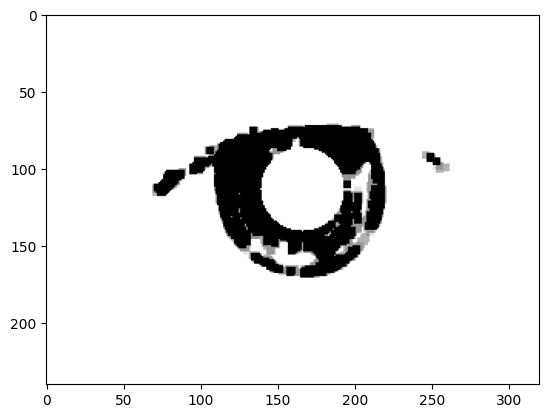

In [167]:
#prepare morphological kernel on binary
kernel = np.ones((2,2), np.uint8)
# Closing
closing = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=4)
binary=closing
#binary to grayscale
binary = cv2.cvtColor(binary, cv2.COLOR_BGR2GRAY)
plt.imshow(binary, cmap='gray')

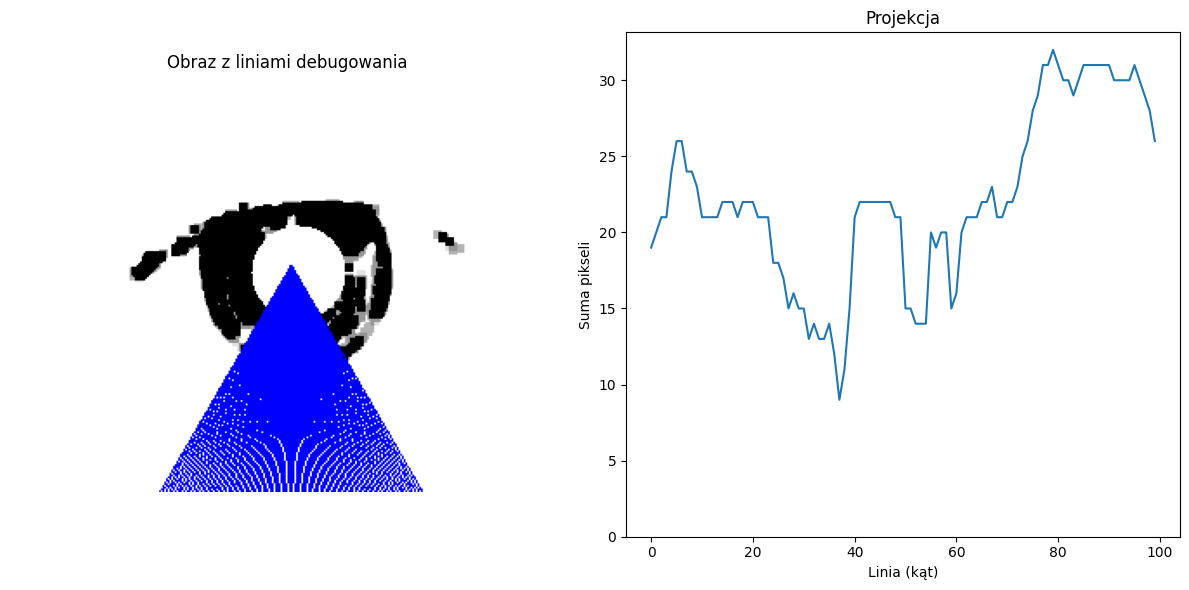

In [168]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_projection(image, center, angle_start, angle_end, num_lines=100):
    """
    Oblicza projekcję obrazu wzdłuż linii od centrum w zakresie kątów.
    
    :param image: Obraz wejściowy (numpy array).
    :param center: Centrum obrazu (x, y).
    :param angle_start: Początkowy kąt w stopniach (np. 5:00 -> -30 stopni).
    :param angle_end: Końcowy kąt w stopniach (np. 11:00 -> 150 stopni).
    :param num_lines: Liczba linii do próbkowania między kątami.
    :return: Projekcja obrazu wzdłuż wybranych linii.
    """
    h, w = image.shape
    projection = []

    # Przekształć kąty na radiany
    angles = np.linspace(np.radians(angle_start), np.radians(angle_end), num_lines)

    for angle in angles:
        # Wyznacz kierunek linii
        dx = np.cos(angle)
        dy = np.sin(angle)

        # Sumuj wartości pikseli wzdłuż linii
        line_sum = 0
        for r in range(max(h, w)):
            x = int(center[0] + r * dx)
            y = int(center[1] + r * dy)

            if 0 <= x < w and 0 <= y < h:
                foo = 1 if image[y, x] == 0 else 0
                # line_sum += image[y, x]
                line_sum += foo
            else:
                break
        
        projection.append(line_sum)

    return projection

def draw_debug_lines(image, center, angle_start, angle_end, num_lines=100):
    """
    Rysuje linie debugowania na obrazie w zakresie kątów.
    
    :param image: Obraz wejściowy (numpy array).
    :param center: Centrum obrazu (x, y).
    :param angle_start: Początkowy kąt w stopniach.
    :param angle_end: Końcowy kąt w stopniach.
    :param num_lines: Liczba linii do narysowania między kątami.
    :return: Obraz z narysowanymi liniami.
    """
    debug_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # Konwersja na BGR
    h, w = image.shape

    # Przekształć kąty na radiany
    angles = np.linspace(np.radians(angle_start), np.radians(angle_end), num_lines)

    for angle in angles:
        # Wyznacz kierunek linii
        dx = np.cos(angle)
        dy = np.sin(angle)

        # Rysuj linię od centrum do krawędzi obrazu
        for r in range(max(h, w)):
            x = int(center[0] + r * dx)
            y = int(center[1] + r * dy)

            if 0 <= x < w and 0 <= y < h:
                debug_image[y, x] = (0, 0, 255)  # Czerwony kolor
            else:
                break

    return debug_image

# Wczytaj obraz (np. binarny obraz)
image = binary  # Używamy obrazu binarnego z notebooka

# Centrum obrazu (np. środek obrazu)
center = (162, 109)

# Projekcja od 5:00 do 11:00
angle_start = 120  # 5:00
angle_end = 60     # 11:00
projection = calculate_projection(image, new_center, angle_start, angle_end)

# Rysowanie linii debugowania
debug_image = draw_debug_lines(image, new_center, angle_start, angle_end)

# Wizualizacja wyników
plt.figure(figsize=(12, 6))

# Oryginalny obraz z liniami debugowania
plt.subplot(1, 2, 1)
plt.title("Obraz z liniami debugowania")
plt.imshow(debug_image)
plt.axis("off")

# Projekcja
plt.subplot(1, 2, 2)
plt.title("Projekcja")
plt.plot(projection)
plt.xlabel("Linia (kąt)")
plt.ylabel("Suma pikseli")
plt.ylim(0) 


plt.tight_layout()
plt.show()

Average projection: 22


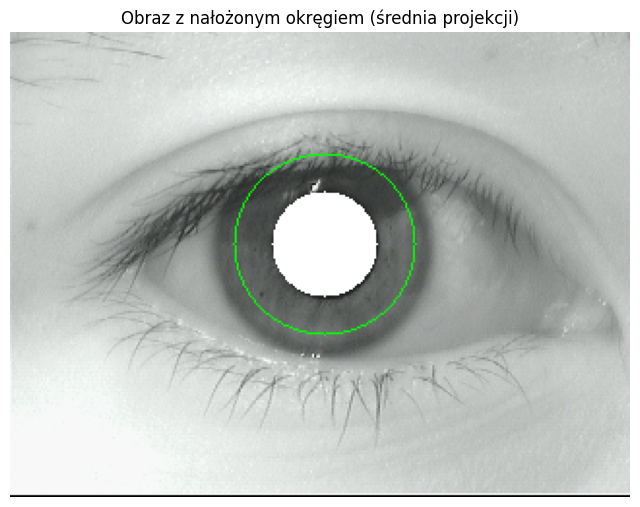

In [169]:
average_projection = int(np.mean(projection))
print(f'Average projection: {average_projection}')
cv2.circle(img_with_pupil, new_center, average_projection + new_radius, (0, 255, 0), 1)
# Wyświetlenie obrazu z nałożonym okręgiem
plt.figure(figsize=(8, 8))
plt.title("Obraz z nałożonym okręgiem (średnia projekcji)")
plt.imshow(cv2.cvtColor(img_with_pupil, cv2.COLOR_BGR2RGB))  # Konwersja BGR -> RGB dla poprawnego wyświetlania w matplotlib
plt.axis("off")
plt.show()

In [170]:
# TODO: Taki pomysł jeszcze że można ulepszyć detekcję środka jeszcze bardziej:
# Algorytm:
# 1. Detekcja przez maksimum tak jak teraz
# 2. Szukamy promienia (poprzez r = średnica/2)
# 3. Jako nowy środek bierzemy środek okręgu o promieniu r
# 4. Rysujemy okrąg o nowym środku i promieniu r

# TODO: Dodatkowa walidacja (zabiezpieczenie od katastrofy):
# 1. Na etapie binaryzacji można odrzucać te artefakty które pojawiają się 
# na obwódce obrazu (powiedzmy padding 10-20%)
# 2. Na etapie wyzanczania projekcji można rozpoznawać czy rozkład jest w miarę taki że jest 
# jedno mocne maksimum
# 3. Po wyznaczeniu ostatecznego okręgu sprawdzić jeszcze raz średnią jasność pikesli 
# wewnątrz okręgu i zmniejszyć okrąg jeśli byłaby zbyt jasna




In [171]:
import numpy as np

class IrisProcessor:
    def __init__(self, image, pupil_center, pupil_radius, iris_radius):
        """
        Initialize the IrisProcessor with the necessary parameters.
        :param image: Input image (2D array).
        :param pupil_center: Tuple (x, y) representing the pupil center.
        :param pupil_radius: Radius of the pupil.
        :param iris_radius: Radius of the iris.
        """
        # Make sure the image is grayscale (2D)
        if len(image.shape) > 2:
            # If it's a color image, take the first channel or convert to grayscale
            # Option 1: Take first channel
            self.image = image[:,:,0]
            # Option 2: Convert to grayscale using average
            # self.image = np.mean(image, axis=2).astype(image.dtype)
        else:
            self.image = image
            
        self.x, self.y = pupil_center
        self.pupil_radius = pupil_radius
        self.iris_radius = iris_radius
        self.iris_rect = None

    # Rest of the class remains the same
    def create_iris_mask(self):
        """
        Create a binary mask for the iris region.
        :return: Binary mask of the iris region.
        """
        rows, cols = self.image.shape
        y, x = np.ogrid[:rows, :cols]
        distance_from_center = np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2)
        mask = (distance_from_center >= self.pupil_radius) & (distance_from_center <= self.iris_radius)
        return mask

    def expand_to_rect(self):
        """
        Convert the iris region into a rectangular representation.
        :return: Rectangular representation of the iris.
        """
        # Create the iris mask
        iris_mask = self.create_iris_mask()

        # Define rectangle dimensions
        width = int(2 * np.pi * self.iris_radius)
        height = int(self.iris_radius - self.pupil_radius)
        self.iris_rect = np.ones((height, width)) * 128  # Initialize rectangle with gray pixels

        # Map pixels from the circular iris to the rectangle
        for y, x in np.argwhere(iris_mask):
            r = np.sqrt((x - self.x) ** 2 + (y - self.y) ** 2)  # Distance from the center
            cos = (x - self.x) / r
            sin = (y - self.y) / r
            theta = np.arctan2(sin, cos)  # Angle in radians
            if theta < 0:
                theta += 2 * np.pi  # Normalize angle to [0, 2π)

            rect_y = int(r - self.pupil_radius)  # Map radius to rectangle height
            rect_y = max(min(height - 1, rect_y), 0)  # Clamp to valid range
            rect_x = int(theta * self.iris_radius)  # Map angle to rectangle width
            rect_x = max(min(width - 1, rect_x), 0)  # Clamp to valid range

            # Assign pixel value from the original image to the rectangle
            self.iris_rect[rect_y, rect_x] = self.image[y, x]

        return self.iris_rect

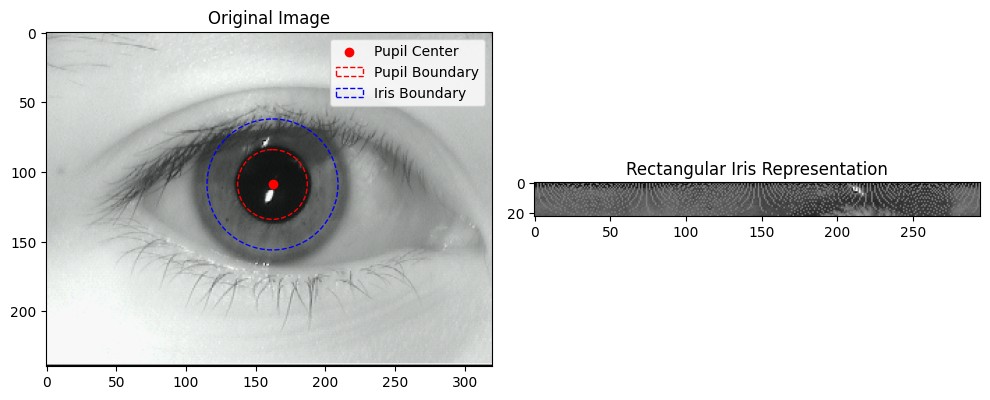

In [172]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Define parameters
# new_center = (150, 120)  # Example pupil center (x, y)
radius_pupil = new_radius
radius_iris = average_projection + new_radius  # Example iris radius

# Initialize the IrisProcessor
iris_processor = IrisProcessor(img_original, new_center, radius_pupil, radius_iris)

# Generate the rectangular representation
iris_rect = iris_processor.expand_to_rect()

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img_original, cmap='gray')

# Draw pupil center point
plt.scatter(new_center[0], new_center[1], color='red', label='Pupil Center')

# Draw pupil circle
pupil_circle = plt.Circle(new_center, new_radius, fill=False, color='red', linestyle='--', label='Pupil Boundary')
plt.gca().add_patch(pupil_circle)

# Draw iris circle
iris_circle = plt.Circle(new_center, new_radius+ average_projection, fill=False, color='blue', linestyle='--', label='Iris Boundary')
plt.gca().add_patch(iris_circle)

plt.legend()

plt.subplot(1, 2, 2)
plt.title("Rectangular Iris Representation")
plt.imshow(iris_rect, cmap='gray')
plt.tight_layout()
plt.show()